# Code demo for Random Forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

plt.rcParams['figure.figsize'] = 15,15

In [2]:
df = pd.read_csv('servo.csv',usecols=['Motor','Screw','Pgain','Vgain','Class'])

In [3]:
df.Motor=df.Motor.astype('category')
df.Screw=df.Screw.astype('category')

In [4]:
df.dtypes

Motor    category
Screw    category
Pgain       int64
Vgain       int64
Class       int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
Motor    167 non-null category
Screw    167 non-null category
Pgain    167 non-null int64
Vgain    167 non-null int64
Class    167 non-null int64
dtypes: category(2), int64(3)
memory usage: 4.8 KB


In [6]:
df.head()

,Motor,Screw,Pgain,Vgain,Class
0,E,E,5,4,4
1,B,D,6,5,11
2,D,D,4,3,6
3,B,A,3,2,48
4,D,B,6,5,6


In [7]:
# split: 75 % for training, 25 % for test:
train_size = 0.75
train_indices = np.random.rand(len(df)) < train_size
train_df = df[train_indices]
test_df = df[~train_indices]

In [8]:
y = df.Class
X = df.drop('Class',axis=1)
X_cat = ['Motor','Screw']
X_num = ['Pgain','Vgain']
X = X[X_cat + X_num]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4,random_state=42)

In [10]:
categorical_pipe = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, X_cat),
     ('num', numerical_pipe, X_num)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=1000, min_samples_split=5,min_samples_leaf=2))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Motor', 'Screw']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Pgain', 'Vgain'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=1000, random_state=42))])

In [11]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.920
RF test accuracy: 0.075


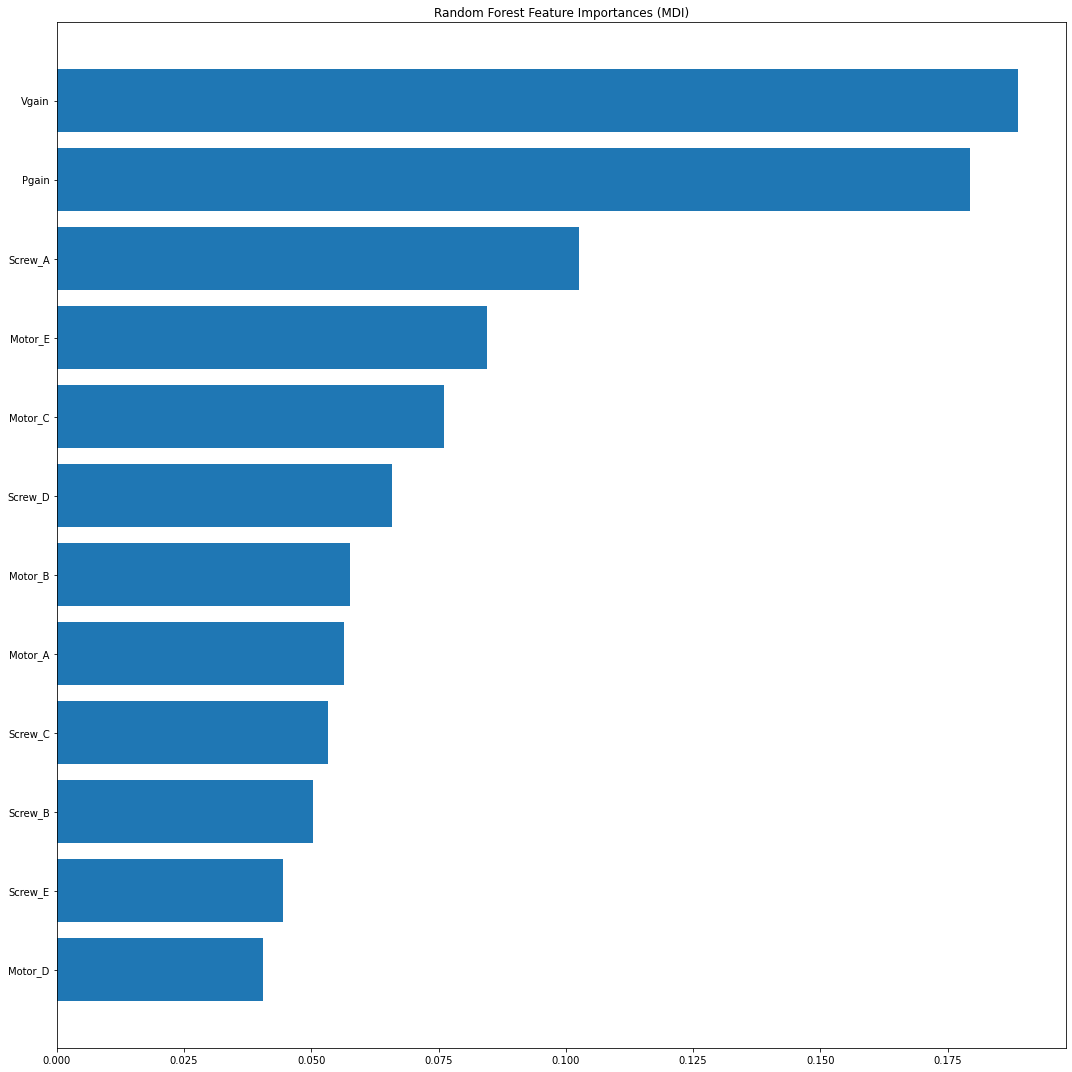

In [12]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=X_cat)
feature_names = np.r_[feature_names, X_num]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

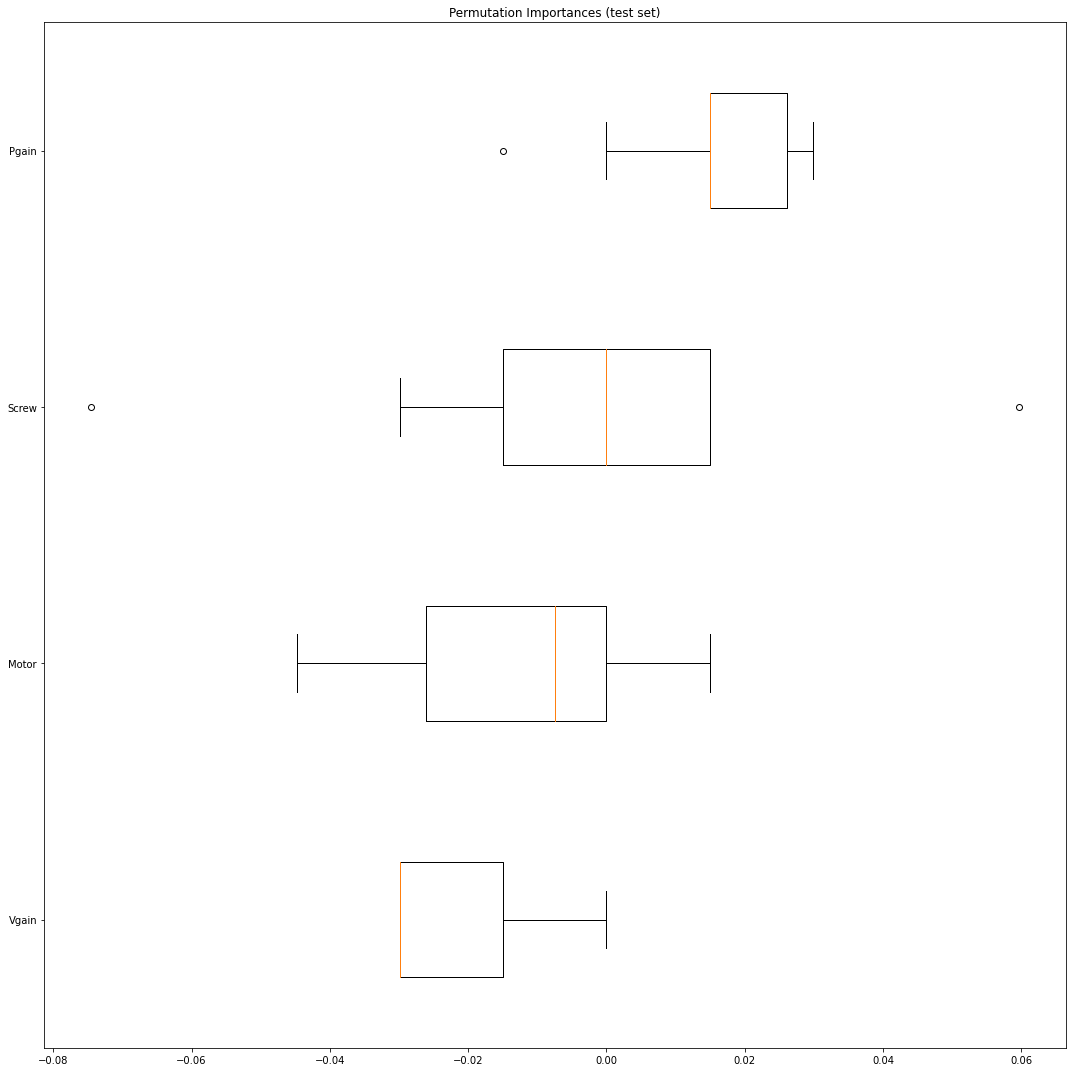

In [13]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Decision Regions CART vs. Random Forest

Let’s look at a simpler problem with just two features to visualize the way that CARTs and Random Forests divide the feature space into decision regions.

First, look a the data:

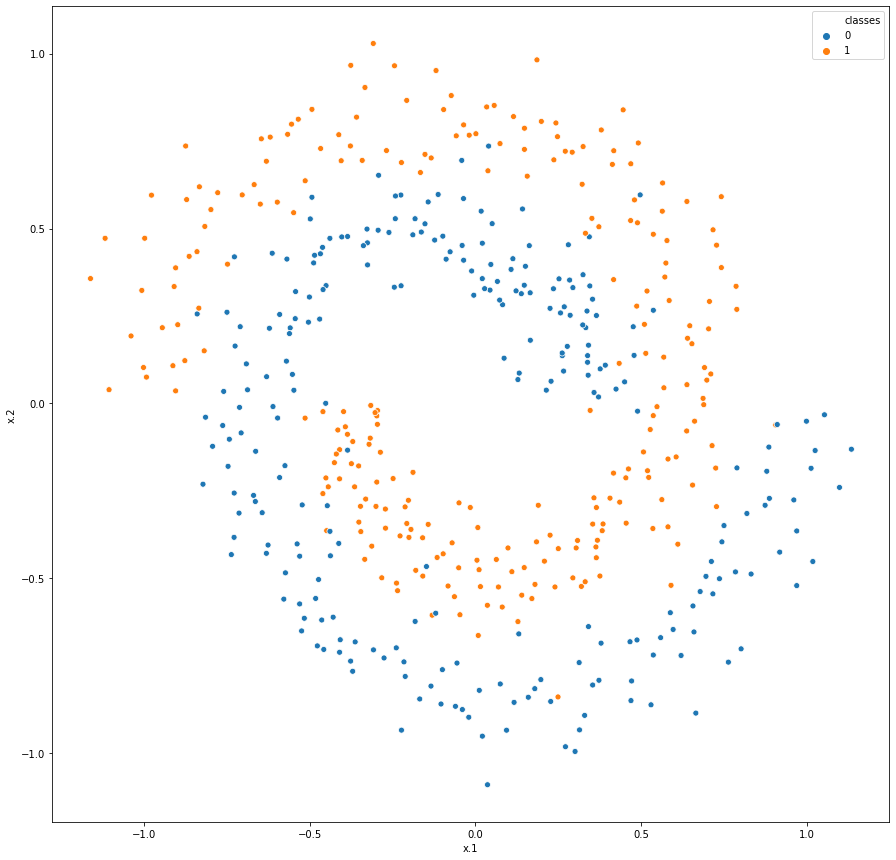

In [14]:
spirals = pd.read_csv('spirals.csv',usecols=['x.1','x.2','classes'])
spirals.classes.replace({1:0,2:1,3:2},inplace=True)
sns.scatterplot(x='x.1',y='x.2',hue='classes',data=spirals);

In [15]:
from utils import plot_decision_boundaries

In [16]:
y = spirals['classes'].values
X = spirals.drop('classes',axis=1)
# X = StandardScaler().fit_transform(X)
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size=.2, random_state=42)

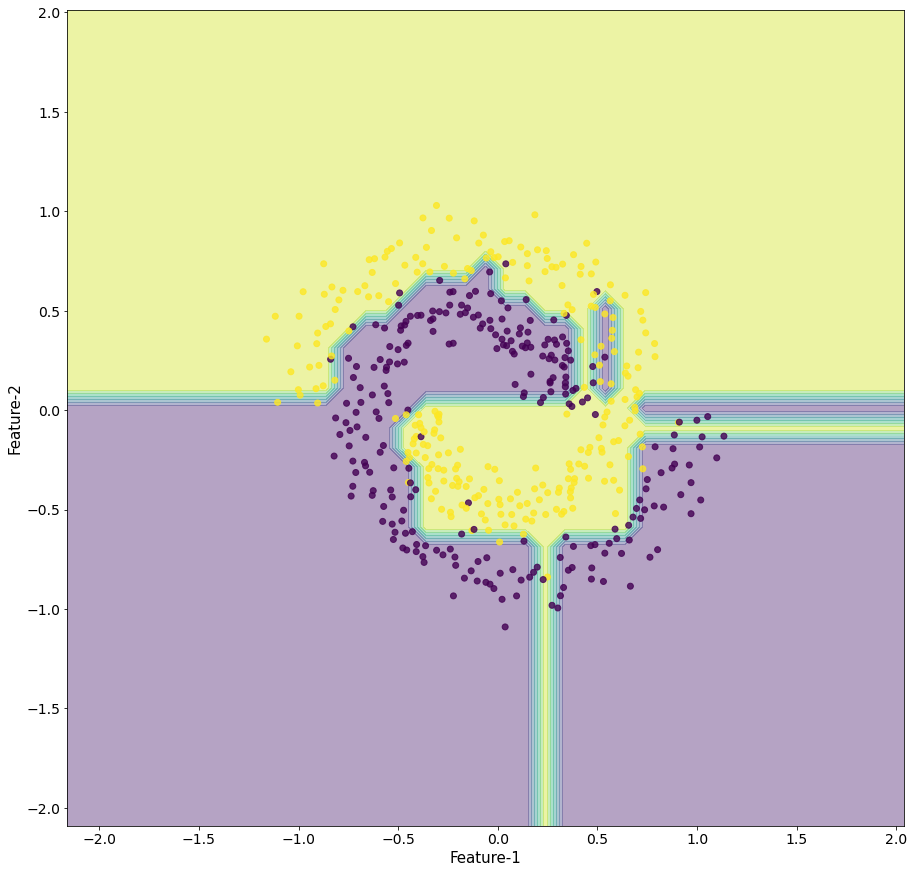

In [17]:
plot_decision_boundaries(X,y,DecisionTreeClassifier);

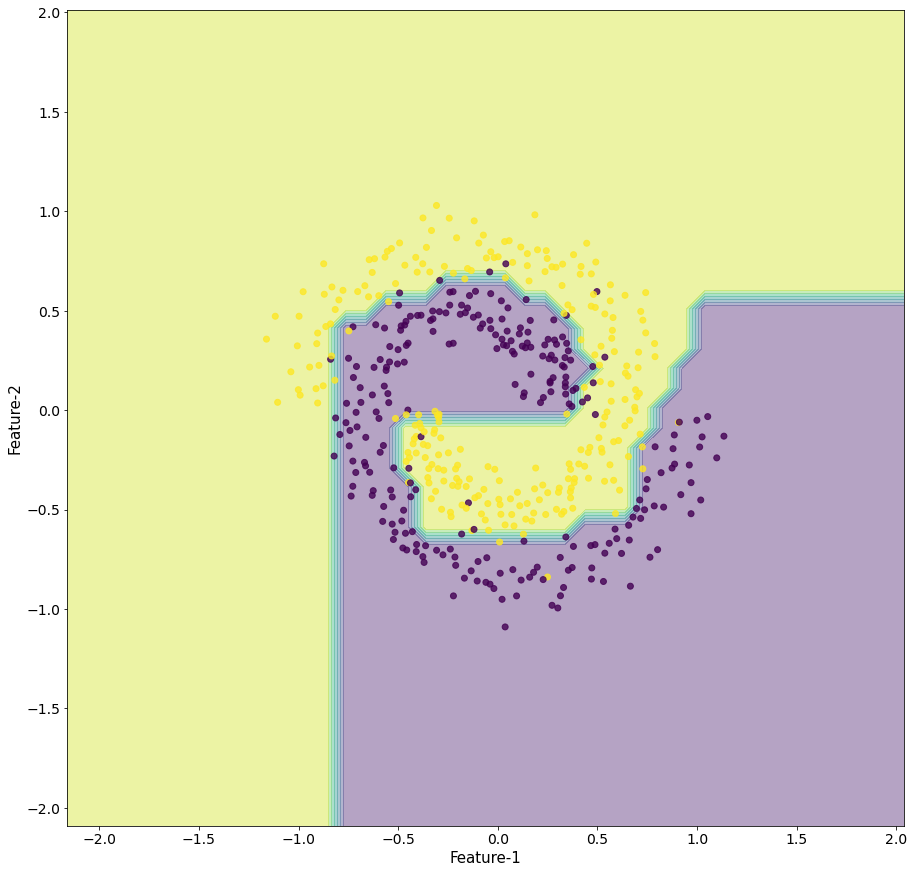

In [18]:
plot_decision_boundaries(X,y,RandomForestClassifier);

## Proximity measures in Random Forests
One neat feature of random forests is that they implicitly calculate a proximity measure (how close a data point is to another): relative frequencies of how often two (OOB-)observations end up in the same terminal
node are easily calculated during the fit. If two observations are “close” in terms of the features that matter for the random forest, they have a “high proximity” in the sense that they will frequently be sorted into the
same terminal node.

We apply this to the spiral data set and try to see, if we could also classify the points based on their proximity. We fit a random forest and extract the proximity distance matrix:

In [19]:
clf = RandomForestClassifier().fit(X,y)

In [20]:
def proximityMatrix(model, X, normalize=True):
    ''' source : https://stackoverflow.com/questions/18703136/proximity-matrix-in-sklearn-ensemble-randomforestclassifier
    '''

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat

In [21]:
spiral_proximity=proximityMatrix(clf,X)

In [22]:
spiral_proximity[:5, :5]

array([[1.  , 0.08, 0.02, 0.  , 0.22],
       [0.08, 1.  , 0.01, 0.  , 0.  ],
       [0.02, 0.01, 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.22, 0.  , 0.  , 0.  , 1.  ]])

[MDS (Multidimensional Scaling)](https://en.wikipedia.org/wiki/Multidimensional_scaling) is a method that takes a matrix containing distances between objects and tries to create a low-dimensional configuration of points (each corresponding to one of these objects) that has the same pairwise distances.
This low-dimensional configuration (typically in 2D) can be very useful to visualize the strcuture of similarity and dissimilarity implied by the distances between high-dimensional vectors or other complex objects. Check
[this blog post](https://www.r-statistics.com/2016/01/multidimensional-scaling-with-r-from-mastering-data-analysis-with-r/) for a nice example of MDS for European capital cities.

We run MDS on the distance matrix derived from the (inverse) proximities and plot the data based on the two dimensions, this won’t work all that well here because so many data points have mutual proximities of 0,
i.e., an “infinite” distance – they never ended up in the same leaf of any tree, ever. . .

In [23]:
def proximity_to_dist(proximity):
    return 1-proximity

In [24]:
spiral_dist = proximity_to_dist(spiral_proximity)
spiral_dist[1:5, 1:5]

array([[0.  , 0.99, 1.  , 1.  ],
       [0.99, 0.  , 1.  , 1.  ],
       [1.  , 1.  , 0.  , 1.  ],
       [1.  , 1.  , 1.  , 0.  ]])

In [25]:
from sklearn import manifold
from sklearn.decomposition import PCA

In [26]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=42,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(spiral_proximity).embedding_

In [27]:
# Rescale the data
pos *= np.sqrt((X ** 2).sum()) / np.sqrt((pos ** 2).sum())
# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X)

pos = clf.fit_transform(pos)

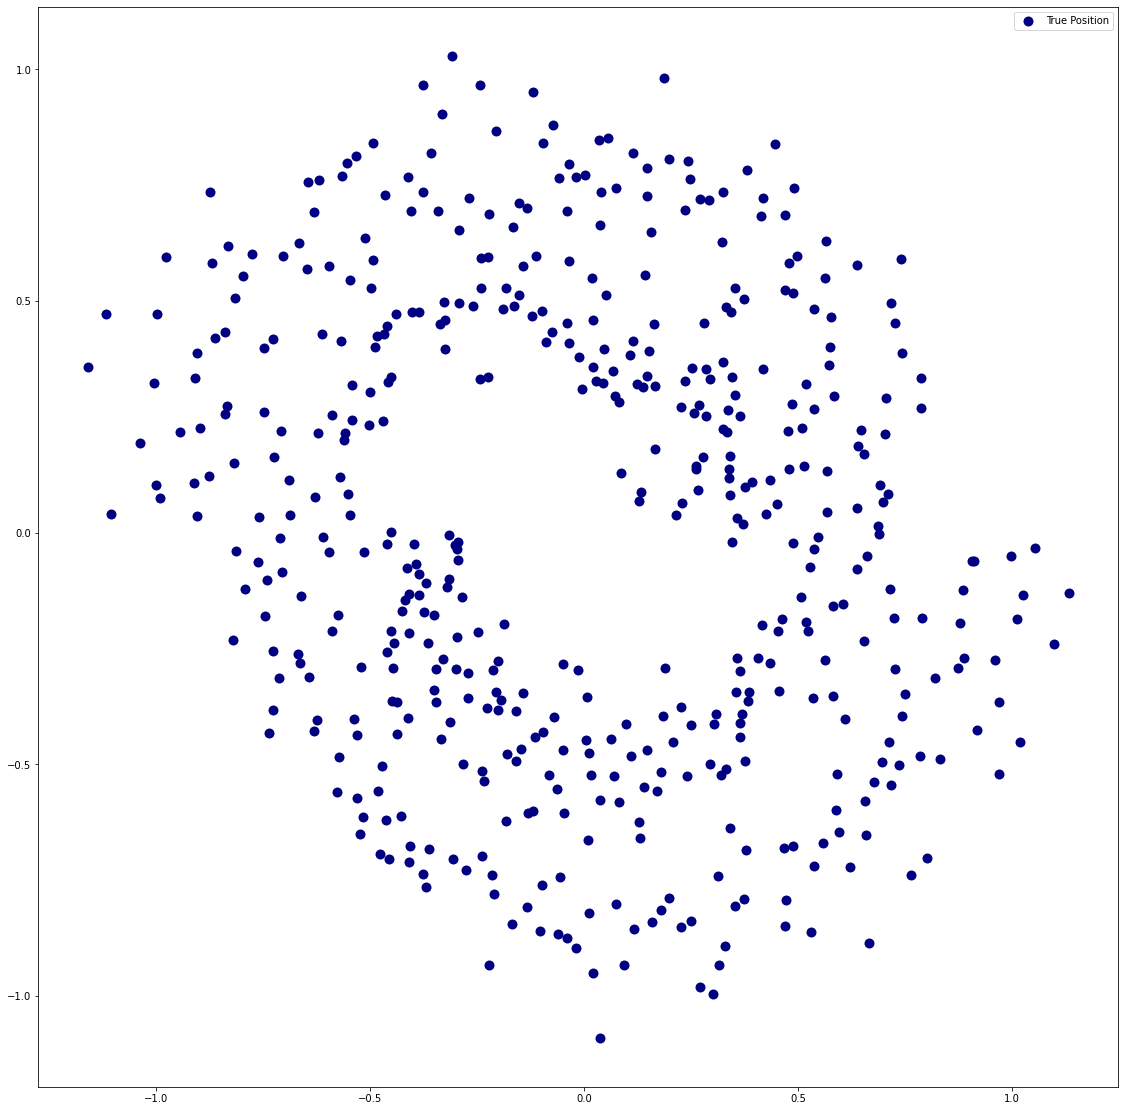

In [29]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(X['x.1'], X['x.2'], color='navy', s=s, lw=0, label='True Position')
plt.scatter(pos[:,0], pos[:,1], color='turquoise', s=s, lw=0, label='MDS')
plt.legend(scatterpoints=1, loc='best', shadow=False);

Some structure seems visible, but this is really most useful for very high-dimensional feature vectors, so let’s
look at such a problem next. . .

## MNIST example
In this exercise we want to train a random forest classifier, s.t. it can be used to identify the handwritten
digits 8 and 9. For that, we’ll use the iconic MNIST data set that contains 28 × 28 greyscale pixel images of
handwritten digits.

In [48]:
mnist_raw = pd.read_csv("https://www.python-course.eu/data/mnist/mnist_train.csv",header=None)

Every row of the MNIST data set contains the label (0-9) and the grayscale of the $28^2$ = 784 pixels of the corresponding image. For example, for the first row, we have :

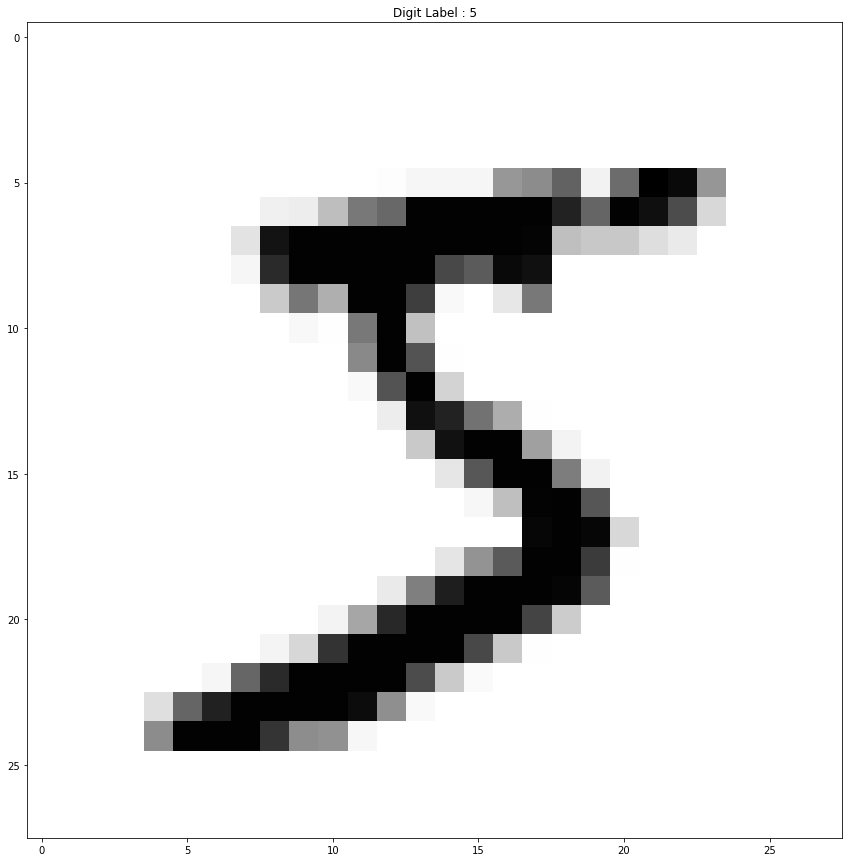

In [63]:
row = 0
plt.imshow(mnist_raw.loc[row,1:].values.reshape((28,28)),cmap='Greys');
plt.title('Digit Label : {}'.format(mnist_raw.loc[row,0]));

In [66]:
mnist_8 = mnist_raw[mnist_raw.loc[:,0]==8]
mnist_9 = mnist_raw[mnist_raw.loc[:,0]==9]

In [67]:
train_size = 150
np.random.seed(42)

In [74]:
train_8_indices = np.random.choice(mnist_8.index, int(train_size / 2), replace = False)
train_9_indices = np.random.choice(mnist_9.index, int(train_size / 2), replace = False)

In [77]:
mnist_89_train = pd.concat([mnist_8.loc[train_8_indices],mnist_9.loc[train_9_indices]])

In [83]:
mnist_89_train.rename({0:'label'},axis=1,inplace=True)

In [84]:
mnist_89_train.head()

,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
45684,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24479,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25320,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34225,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47942,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
mnist_89_train.label.value_counts()

9    75
8    75
Name: label, dtype: int64

In [88]:
mnist_89_test = pd.concat([mnist_8.drop(train_8_indices),mnist_9.drop(train_9_indices)])

In [92]:
mnist_89_test.rename({0:'label'},axis=1,inplace=True)

In [104]:
X_train=mnist_89_train.iloc[:,1:].values
y_train=mnist_89_train.iloc[:,0].values

X_test=mnist_89_test.iloc[:,1:].values
y_test=mnist_89_test.iloc[:,0].values

In [105]:
clf = RandomForestClassifier().fit(X_train,y_train)

In [107]:
y_pred=clf.predict(X_test)

In [114]:
np.mean(y_pred!=y_test) # accuracy

0.05193133047210301

In [110]:
mnist_89_proximity=proximityMatrix(clf,X_test)

In [113]:
mnist_89_dist = proximity_to_dist(mnist_89_proximity)

In [115]:
mnist_89_dist.shape

(11650, 11650)